# ResNetV2-152 实现口腔癌识别

本项目基于 ResNetV2-152 网络，采集口腔病变位置特征，判别是否是口腔癌变。

## 数据集准备与加载


In [1]:
%%capture captured_output
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [8]:
batch_size = 128  # 批量大小
image_size = 32  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 2 # 分类数量

## 数据集准备
通过`git lfs`下载魔乐社区的数据集。

In [4]:
!git lfs install
!git clone https://modelers.cn/xsir/orcal-cancer.git
!unzip -q orcal-cancer/dataset.zip -d orcal-cancer/

Git LFS initialized.
正克隆到 'orcal-cancer'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [9]:
import os
from PIL import Image, UnidentifiedImageError

def delete_invalid_jpeg_files(dataset_path):
    """
    删除所有非.jpg/.jpeg文件及无法以JPEG格式读取的图片
    """
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            ext = os.path.splitext(file)[1].lower()

            # 删除非jpg/jpeg文件
            if ext not in ('.jpg', '.jpeg'):
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"删除失败[{file_path}]: {str(e)}")
                continue

            # 验证JPEG文件内容
            try:
                with Image.open(file_path) as img:
                    if img.format != 'JPEG':
                        raise ValueError("文件格式不符")
            except (UnidentifiedImageError, ValueError, Exception) as e:
                try:
                    os.remove(file_path)
                except Exception as delete_error:
                    print(f"删除失败[{file_path}]: {str(delete_error)}")

if __name__ == "__main__":
    dataset_path = "./orcal-cancer/dataset"
    
    if not os.path.isdir(dataset_path):
        print("错误：路径不存在或不是目录")
    else:
        delete_invalid_jpeg_files(dataset_path)
        print("清理完成")

# 使用前请先安装Pillow库: pip install Pillow
# 注意：操作不可逆，建议先备份数据！

清理完成


In [6]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from typing import Type, Union, List, Optional
from mindspore import nn, train
from mindspore.common.initializer import Normal
import os
import time
# 数据集目录路径
data_path_train = "./orcal-cancer/dataset/train/"
data_path_val = "./orcal-cancer/dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


对训练数据集进行可视化。

In [7]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")

classes = ["normal", "Oral Cancer"]


# 训练数据集的前六张图片
# plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     image_trans = np.transpose(images[i], (1, 2, 0))
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])
#     image_trans = std * image_trans + mean
#     image_trans = np.clip(image_trans, 0, 1)
#     plt.title(f"{classes[labels[i]]}")
#     plt.imshow(image_trans)
#     plt.axis("off")
# plt.show()

Image shape: (128, 3, 128, 128), Label shape: (128,)
Labels: [0 1 0 0 0 0]


### ResNetV2-152 网络

相较于 ResNetV1，在卷积结构上采用了预激活（pre-activation）设计，如图（e）所示，采用 Batch Normalization（BN）-> ReLU ->  卷积（Conv） 的顺序。由于预激活单元中的所有权重层输入都是归一化后的信号，这不仅使网络训练更加稳定，还提升了泛化性能。

![](https://openi.pcl.ac.cn/attachments/ee832864-27c7-4db3-991a-dba1e4deed8f?type=0)

在整个网络架构上，与 ResNetV1 相似，包含 5 个卷积结构、1 个全局平均池化（Global Average Pooling）和 1 个全连接层（Fully Connected, FC）：

+ **conv1**：输入图片大小为$32\times32$，输入channel为3。首先经过一个卷积核数量为64，卷积核大小为$7\times7$，stride为2的卷积层；然后通过一个Batch Normalization层；最后通过Reul激活函数。该层输出feature map大小为$16\times16$，输出channel为64。
+ **conv2_x**：输入feature map大小为$16\times16$，输入channel为64。首先经过一个卷积核大小为$3\times3$，stride为2的最大下采样池化操作；然后堆叠3个$[1\times1，64；3\times3，64；1\times1，256]$结构的Bottleneck。该层输出feature map大小为$8\times8$，输出channel为256。
+ **conv3_x**：输入feature map大小为$8\times8$，输入channel为256。该层堆叠8个[1×1，128；3×3，128；1×1，512]结构的Bottleneck。该层输出feature map大小为$4\times4$，输出channel为512。
+ **conv4_x**：输入feature map大小为$4\times4$，输入channel为512。该层堆叠36个[1×1，256；3×3，256；1×1，1024]结构的Bottleneck。该层输出feature map大小为$2\times2$，输出channel为1024。
+ **conv5_x**：输入feature map大小为$2\times2$，输入channel为1024。该层堆叠3个[1×1，512；3×3，512；1×1，2048]结构的Bottleneck。该层输出feature map大小为$1\times1$，输出channel为2048。
+ **global average pooling & fc**：输入channel为2048，输出channel为分类的类别数。

In [9]:
import mindspore.nn as nn
from mindspore.ops import operations as P

class PreActBottleNeck(nn.Cell):
    """ PreActBottleNeck """
    expansion = 4

    def __init__(self,
                 in_planes,
                 planes,
                 stride=1):
        super(PreActBottleNeck, self).__init__()

        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(in_planes, eps=1e-5, momentum=0.9)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-5, momentum=0.9)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, pad_mode='pad')
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-5, momentum=0.9)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, stride=1)

        self.downtown = False
        if stride != 1 or in_planes != self.expansion*planes:
            self.downtown = True
            self.shortcut = nn.SequentialCell([nn.Conv2d(in_planes, self.expansion*planes,
                                                         kernel_size=1, stride=stride)])

        self.add = P.Add()

    def construct(self, x):
        """ construct network """
        out = self.bn1(x)
        out = self.relu(out)
        if self.downtown:
            identity = self.shortcut(out)
        else:
            identity = x
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        out = self.add(out, identity)
        return out


class PreActResNet(nn.Cell):
    """ PreActResNet """
    def __init__(self,
                 block,
                 num_blocks,
                 in_planes,
                 planes,
                 strides,
                 low_memory,
                 num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = in_planes
        self.low_memory = low_memory

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2)
        self.conv2 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, pad_mode='pad', padding=1)

        self.layer1 = self._make_layer(block,
                                       planes=planes[0],
                                       num_blocks=num_blocks[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       planes=planes[1],
                                       num_blocks=num_blocks[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       planes=planes[2],
                                       num_blocks=num_blocks[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       planes=planes[3],
                                       num_blocks=num_blocks[3],
                                       stride=strides[3])
        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Dense(planes[3]*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        strides = [stride] + [1]*(num_blocks-1)

        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion

        return nn.SequentialCell(layers)

    def construct(self, x):
        """ construct network """
        if self.low_memory:
            out = self.conv1(x)
        else:
            out = self.conv2(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.mean(out, (2, 3))
        out = out.view(out.shape[0], -1)
        out = self.linear(out)

        return out


def PreActResNet152(class_num=10, low_memory=False):
    return PreActResNet(PreActBottleNeck,
                        num_blocks=[3, 8, 36, 3],
                        in_planes=64,
                        planes=[64, 128, 256, 512],
                        strides=[1, 2, 2, 2],
                        low_memory=low_memory,
                        num_classes=class_num)

## 模型训练与评估
调用`PreActResNet`构造 ResNetV2-152 模型，每隔10个epoch打印训练的损失值和评估精度，并保存评估精度最高的ckpt文件（resnetV2_152-best.ckpt）到当前路径的./BestCheckPoint下。

由于预训练模型全连接层（fc）的输出大小（对应参数`num_classes`）为1000， 为了成功加载预训练权重，我们将模型的全连接输出大小设置为默认的1000。数据集共有2个分类.

> 此处我们展示了30个epochs的训练过程。

In [10]:
# 定义ResNetV2_152网络
network = PreActResNet152(class_num=2)


In [11]:
# 设置学习率
num_epochs = 30
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

In [12]:
import os

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnetV2_152-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [13]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)

    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels)
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # 准确率

    return acc

In [14]:
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    if (epoch + 1) % 5 == 0:
        print("-" * 50)
        print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
            epoch+1, num_epochs, curr_loss, curr_acc
        ))

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
..........--------------------------------------------------
Epoch: [  5/ 30], Average Train Loss: [0.661], Accuracy: [0.630]
--------------------------------------------------
Epoch: [ 10/ 30], Average Train Loss: [0.632], Accuracy: [0.765]
--------------------------------------------------
Epoch: [ 15/ 30], Average Train Loss: [0.604], Accuracy: [0.753]
--------------------------------------------------
Epoch: [ 20/ 30], Average Train Loss: [0.592], Accuracy: [0.741]
--------------------------------------------------
Epoch: [ 25/ 30], Average Train Loss: [0.602], Accuracy: [0.778]
--------------------------------------------------
Epoch: [ 30/ 30], Average Train Loss: [0.590], Accuracy: [0.753]
End of validation the best Accuracy is:  0.790, save the best ckpt file in ./BestCheckpoint/resnetV2_152-best.ckpt


## 可视化模型预测

定义`visualize_model`函数，使用上述验证精度最高的模型对测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

> 由上面的结果可知，30个epochs下模型在验证数据集的预测准确率在70%左右。

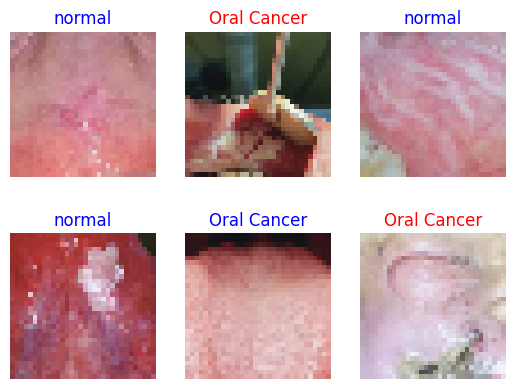

In [16]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, dataset_val):
    net = PreActResNet152(class_num=2)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)